In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [10]:
adata = sc.read_h5ad('../data/mtDNA_DSB_5k_clustered_LLM_anno.h5ad')

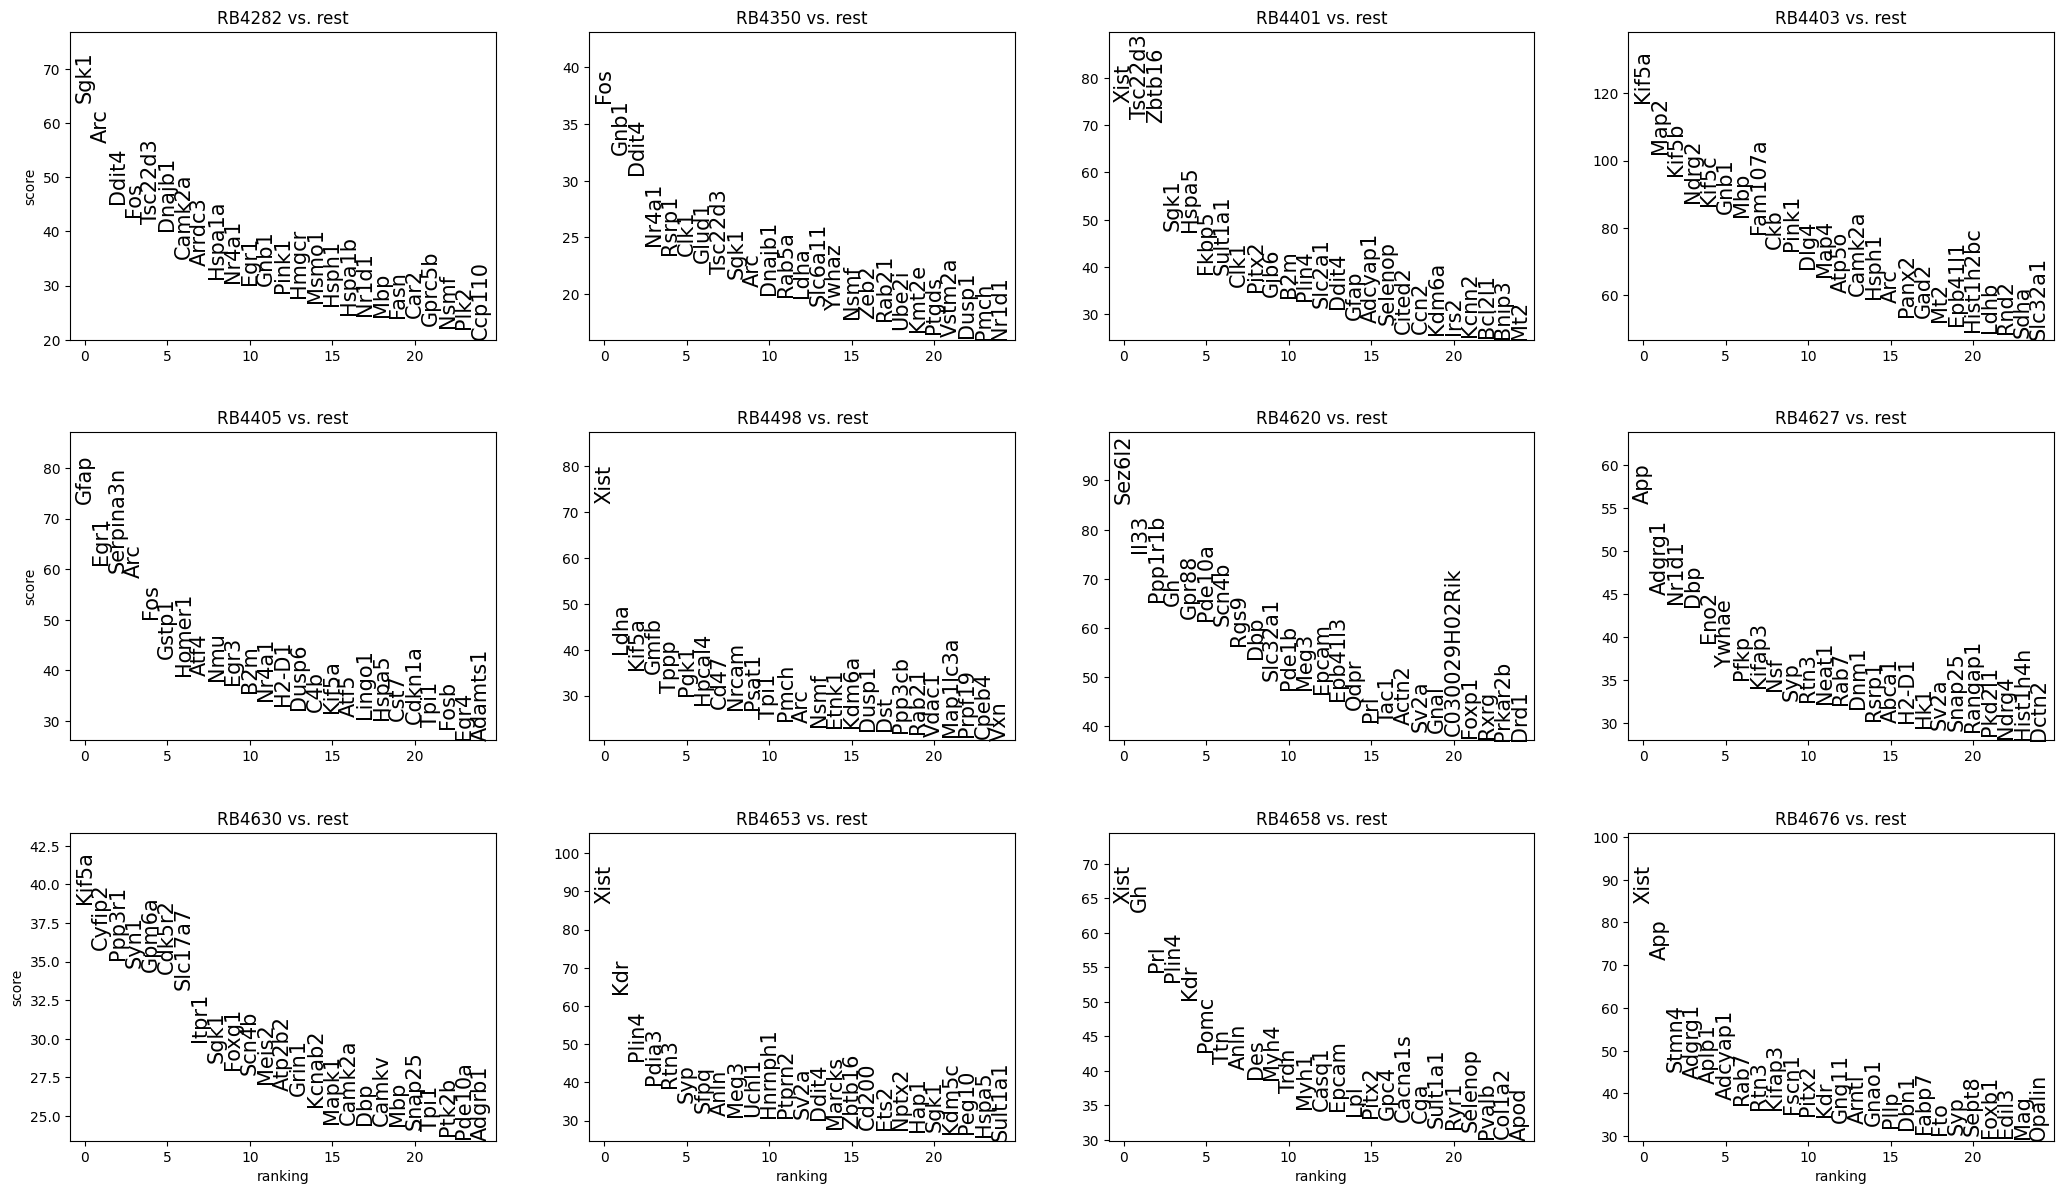

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,RB4282,Sgk1,63.659225,0.924674,0.0,0.0
1,RB4282,Arc,56.295242,0.721150,0.0,0.0
2,RB4282,Ddit4,45.068020,0.478253,0.0,0.0
3,RB4282,Fos,42.649483,0.759690,0.0,0.0
4,RB4282,Tsc22d3,41.420624,0.400506,0.0,0.0


In [67]:
# --- Find marker genes per cluster ---
sc.tl.rank_genes_groups(adata, groupby="sample_id", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, fontsize = 15)

# get a tidy table of top markers
markers = sc.get.rank_genes_groups_df(adata, group=None)
markers.head()

In [68]:
import pandas as pd

def get_DEGs(adata, n_genes=100):
    res = adata.uns['rank_genes_groups']
    groups = res['names'].dtype.names
    dfs = []
    for g in groups:
        df = pd.DataFrame({
            "gene": res['names'][g],
            "logfoldchange": res['logfoldchanges'][g],
            "pval_adj": res['pvals_adj'][g],
            "group": g
        })
        dfs.append(df.head(n_genes))
    return pd.concat(dfs)

deg_table = get_DEGs(adata, n_genes=10)

In [69]:
deg_table

,gene,logfoldchange,pval_adj,group
0,Sgk1,0.924674,0.000000e+00,RB4282
1,Arc,0.721150,0.000000e+00,RB4282
2,Ddit4,0.478253,0.000000e+00,RB4282
3,Fos,0.759690,0.000000e+00,RB4282
4,Tsc22d3,0.400506,0.000000e+00,RB4282
...,...,...,...,...
5,Adcyap1,1.045243,0.000000e+00,RB4676
6,Rab7,0.175686,8.133951e-301,RB4676
7,Rtn3,0.178376,9.412153e-285,RB4676
8,Kifap3,0.377064,4.812487e-282,RB4676


In [70]:
import numpy as np

# compute variance across runs for each gene
mean_per_run = adata.to_df().groupby(adata.obs["sample_id"]).mean()
var_across_runs = mean_per_run.var(axis=0)

# top varying genes
top_var_genes = var_across_runs.sort_values(ascending=False).head(50)

In [71]:
top_var_genes

Mbp        0.006675
Kif5a      0.002208
Meg3       0.001507
Cnp        0.001491
Cldn11     0.001373
Aplp1      0.001291
Camk2a     0.001094
Ptgds      0.001070
Mal        0.001060
Gh         0.001038
Fam107a    0.000802
Gfap       0.000798
Car2       0.000757
Mt2        0.000710
App        0.000691
Map2       0.000684
Tsc22d3    0.000579
Ckb        0.000570
Stmn4      0.000495
Gnb1       0.000473
Ndrg2      0.000469
Arc        0.000469
Eno2       0.000426
Ermn       0.000426
Aldoc      0.000405
Sgk1       0.000400
Snap25     0.000399
Sept4      0.000388
Kif5b      0.000383
Xist       0.000379
Hpcal4     0.000376
Selenop    0.000364
Kif5c      0.000356
Mog        0.000344
Kdr        0.000343
Prl        0.000332
Nsmf       0.000328
Slc6a11    0.000306
Dbp        0.000286
Gpr88      0.000276
Camk2b     0.000264
B2m        0.000241
Apod       0.000233
Slc32a1    0.000224
Stxbp1     0.000219
Qdpr       0.000218
Hspa5      0.000216
Ywhaz      0.000205
Ppp1r1b    0.000205
Atp2b2     0.000203


In [49]:
import re

# extract "RB####" from the run string and put into new column
adata.obs["sample_id"] = adata.obs["run"].str.extract(r"(RB\d+)")

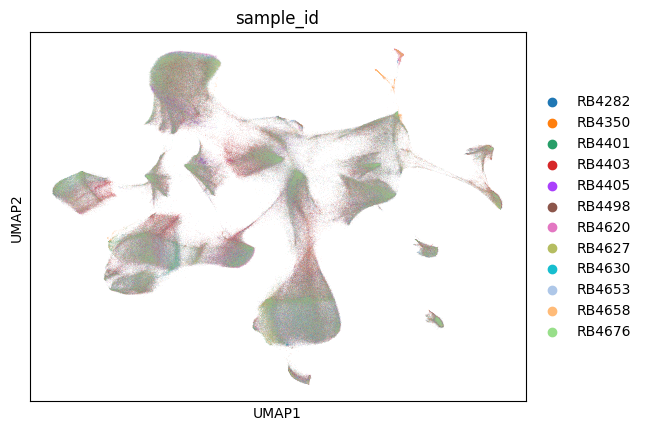

In [51]:
sc.pl.umap(adata, color="sample_id")

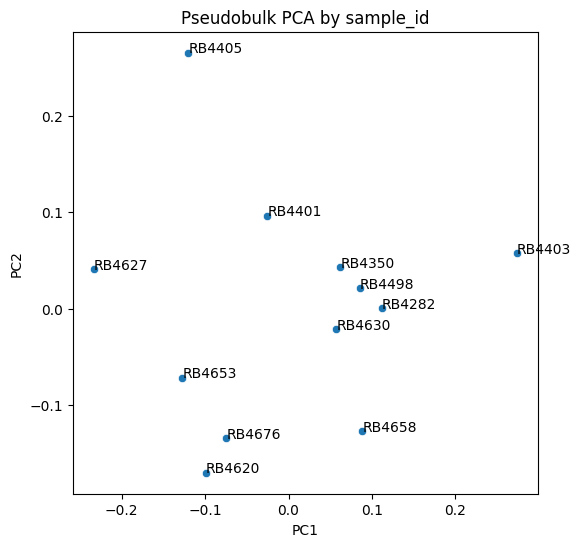

In [54]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Average expression per sample_id
pb = adata.to_df().groupby(adata.obs["sample_id"]).mean()

# Run PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(pb)

df_pca = pd.DataFrame(coords, index=pb.index, columns=["PC1","PC2"])

# Plot
plt.figure(figsize=(6,6))
sns.scatterplot(x="PC1", y="PC2", data=df_pca)
for i, txt in enumerate(df_pca.index):
    plt.annotate(txt, (df_pca.PC1[i], df_pca.PC2[i]))
plt.title("Pseudobulk PCA by sample_id")
plt.show()

In [56]:
import pandas as pd
loadings = pd.Series(pca.components_[0], index=pb.columns)  # PC1 loadings
print(loadings.sort_values(ascending=False).head(20))

Mbp        0.528226
Kif5a      0.269194
Cnp        0.204408
Camk2a     0.193287
Fam107a    0.155195
Mal        0.144871
Map2       0.139523
Kif5b      0.123051
Cldn11     0.121177
Gnb1       0.112989
Ndrg2      0.111173
Sept4      0.108990
Ptgds      0.104996
Aldoc      0.101828
Nsmf       0.099866
Kif5c      0.098106
Ckb        0.095488
Gprc5b     0.090579
Pink1      0.090385
Slc6a11    0.088682
dtype: float32


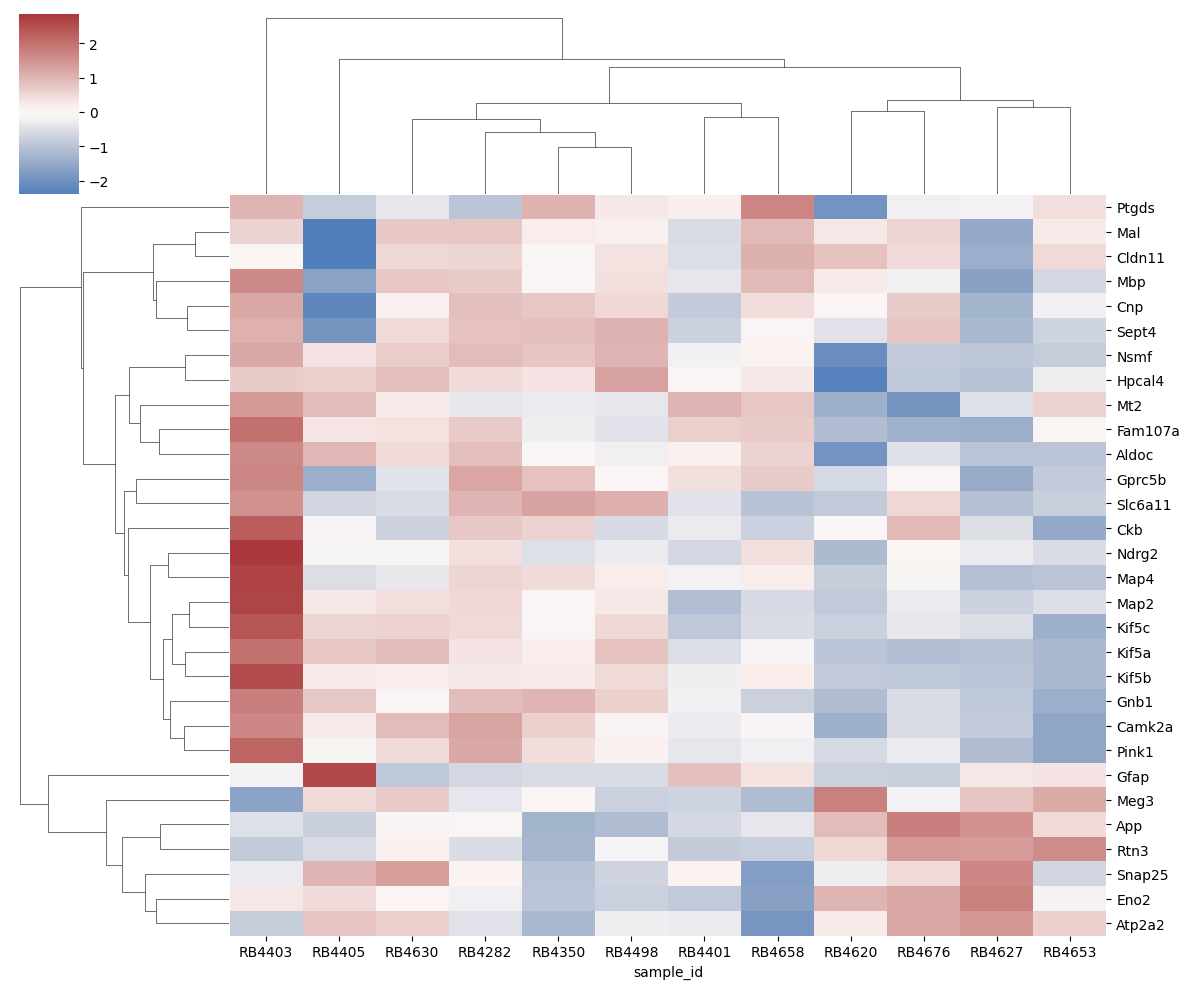

In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Get top PC1 loadings (absolute value to get both positive & negative drivers) ---
pc1_loadings = pd.Series(pca.components_[0], index=pb.columns)
top_genes = pc1_loadings.abs().sort_values(ascending=False).head(30).index

# --- Subset pseudobulk matrix ---
pb_pc1 = pb[top_genes]

# --- Z-score per gene ---
pb_pc1_scaled = (pb_pc1 - pb_pc1.mean(axis=0)) / pb_pc1.std(axis=0)

# --- Clustered heatmap ---
sns.clustermap(
    pb_pc1_scaled.T,
    col_cluster=True, row_cluster=True,
    cmap="vlag", center=0,
    figsize=(12, 10),
    xticklabels=True, yticklabels=True
)
plt.show()

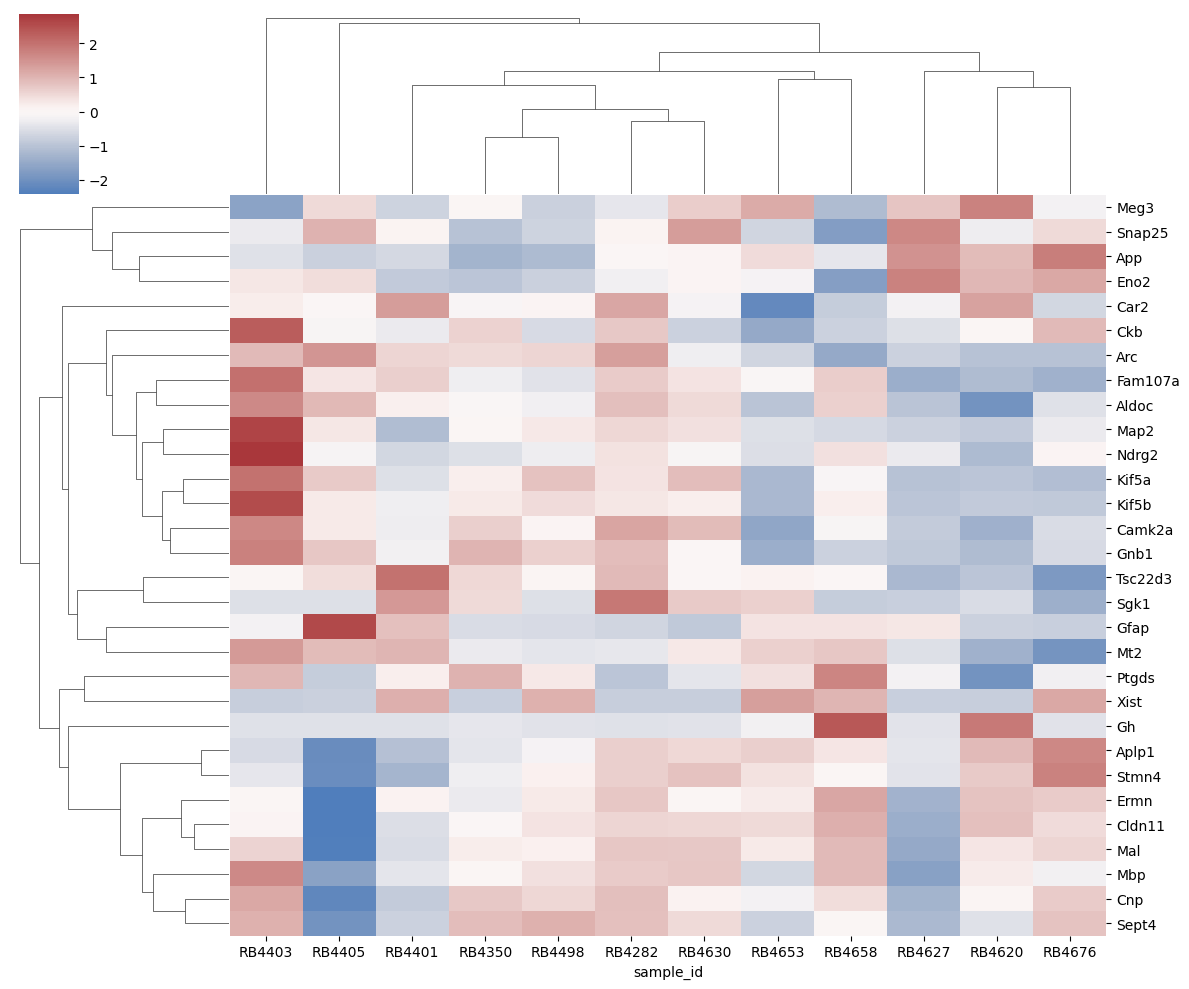

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1. Pseudobulk: average per sample_id ---
pb = adata.to_df().groupby(adata.obs["sample_id"]).mean()

# --- Step 2. Select top variable genes ---
top_var = pb.var(axis=0).sort_values(ascending=False).head(30).index
pb_top = pb[top_var]

# --- Step 3. Scale by gene (z-score) ---
pb_scaled = (pb_top - pb_top.mean(axis=0)) / pb_top.std(axis=0)

# --- Step 4. Clustered heatmap ---
sns.clustermap(
    pb_scaled.T,  # genes as rows
    col_cluster=True, row_cluster=True,
    cmap="vlag", center=0,
    figsize=(12, 10),
    xticklabels=True, yticklabels=True
)
plt.show()